# SIR model with constant transmission rate

Solving the SIR model with constant transmission rate $\beta$ and recovery rate $\delta$.

$$
\begin{cases}
\frac{dS}{dt} &= -\frac{\beta}{N} I S, \\
\frac{dI}{dt} &= \frac{\beta}{N} I S - \delta I, \\
\frac{dR}{dt} &= \delta I,
\end{cases}
$$

where $t \in [0, 90]$ and with the initial conditions $S(0) = N - 1$, $I(0) = 1$, and $R(0) = 0$.

## Environment Setup

Load .env file, which specifies which backend DeepXDE should use

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import torch
import deepxde as dde
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Log framework versions, expected to match the environment.yaml

In [3]:
print("using PyTorch version:", torch.__version__)
print("using DeepXDE version:", dde.__version__)

using PyTorch version: 2.5.1
using DeepXDE version: 1.12.2


Enable latex in matplotlib and set seaborn theme.

In [4]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_theme(style="darkgrid")

Set random seed for reproducibility

In [5]:
seed = 2322

np.random.seed(seed)
torch.manual_seed(seed)
dde.config.set_random_seed(seed)

## Generate synthetic data

Building a SIR model to generate a discrete synthetic dataset in a closed time interval.

This dataset will be used as a starting point for creating both the true solution used during the l2 regularization term and observed data used during the training of the network.

The following parameters are used (using Italy as reference):

In [6]:
N = 56e6  # total population
delta = 1 / 5  # recovery rate (1 / mean infectious period)
r0 = 3.0  # basic reproduction number
beta = delta * r0  # transmission rate

The following time interval is used:

In [7]:
T0, TF = 0, 90  # (days)

Define the SIR model and the initial conditions.

In [8]:
def SIR(x, t, delta, beta, N):
  S, I, R = x
  _lambda = beta * I / N
  dSdt = -_lambda * S
  dIdt = _lambda * S - delta * I
  dRdt = delta * I
  return [dSdt, dIdt, dRdt]


S0 = N - 1
I0 = 1
R0 = 0
x0 = [S0, I0, R0]

Define a function to generate a discrete solution for the SIR model based on a time interval.

In [9]:
def solve_sir(t):
  x = odeint(SIR, x0, t, args=(delta, beta, N))
  S = x[:, 0]
  I = x[:, 1]
  R = x[:, 2]
  return S, I, R

Generate a synthetic dataset and a synthetic observation of $I(t)$ by adding some noise to the true solution.

In [10]:
t_data = np.linspace(T0, TF, TF - T0)
S_data, I_data, R_data = solve_sir(t_data)

I_obs = np.random.poisson(I_data)

Plot the synthetic dataset and the observed $I(t)$.

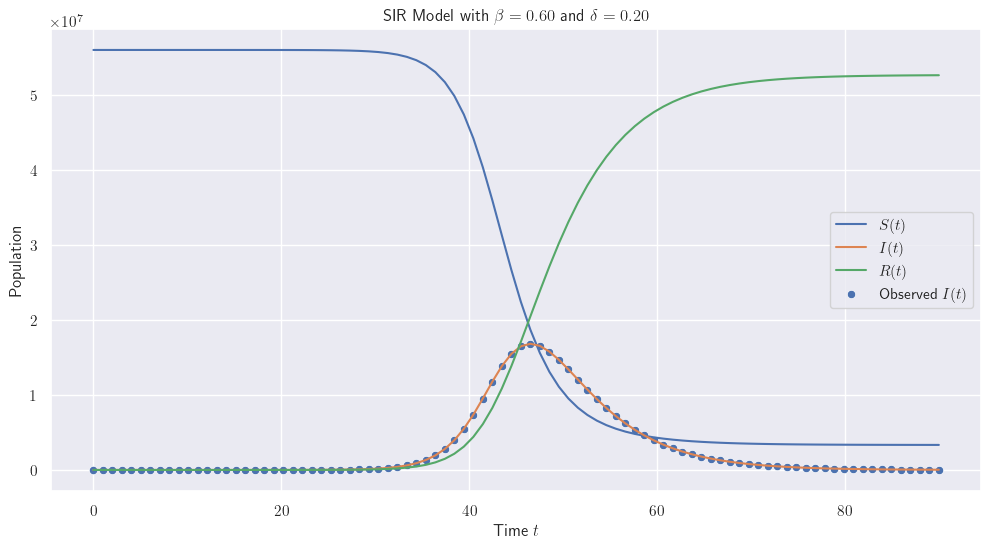

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.lineplot(x=t_data, y=S_data, ax=ax, label=r"$S(t)$")
sns.lineplot(x=t_data, y=I_data, ax=ax, label=r"$I(t)$")
sns.lineplot(x=t_data, y=R_data, ax=ax, label=r"$R(t)$")
sns.scatterplot(x=t_data, y=I_obs, ax=ax, label=r"Observed $I(t)$")

plt.title(
  r"SIR Model with $\beta = {:.2f}$ and $\delta = {:.2f}$".format(beta, delta)
)
plt.xlabel(r"Time $t$")
plt.ylabel(r"Population")

plt.savefig("synthetic_data.png")

Scale both dataset and observation by a constant $C$ and into a time interval $[0, 1]$.

This is necessary to avoid numerical instability during the training of the network.

In [12]:
C = 1e5

t_data_sc = t_data / TF
S_data_sc = S_data / C
I_data_sc = I_data / C
R_data_sc = R_data / C

I_obs_sc = I_obs / C

Create a function to compute the true solution for any time point.

It uses an interpolation function applied on a more dense time interval.

In [13]:
t_dense = np.linspace(T0, TF, 1000)
S_dense, I_dense, R_dense = solve_sir(t_dense)

t_dense_sc = t_dense / TF
S_dense_sc = S_dense / C
I_dense_sc = I_dense / C
R_dense_sc = R_dense / C

S_interp = interp1d(t_dense_sc, S_dense, kind='cubic', fill_value="extrapolate")
I_interp = interp1d(t_dense_sc, I_dense, kind='cubic', fill_value="extrapolate")
R_interp = interp1d(t_dense_sc, R_dense, kind='cubic', fill_value="extrapolate")


def true_solution(t):
  t = t.flatten()
  S = S_interp(t)
  I = I_interp(t)
  R = R_interp(t)
  return np.hstack((S.reshape(-1, 1), I.reshape(-1, 1), R.reshape(-1, 1)))

## Modelling the Network


Define the time domain geometry, scaled to the range [0, 1].

In [14]:
geom = dde.geometry.TimeDomain(T0 / TF, TF / TF)

Define the beta parameter as a trainable variable with initial guess.

In [15]:
beta_var = dde.Variable(0.5)

Define the ODE system.

In [16]:
def ode_system(t, y):
  S = y[:, 0:1]
  I = y[:, 1:2]
  R = y[:, 2:3]
  dS_t = dde.grad.jacobian(y, t, i=0)
  dI_t = dde.grad.jacobian(y, t, i=1)
  dR_t = dde.grad.jacobian(y, t, i=2)

  _lambda = beta_var * I / N
  res_s = dS_t - (- _lambda * S)
  res_i = dI_t - (_lambda * S - delta * I)
  res_r = dR_t - (delta * I)
  return torch.cat([res_s, res_i, res_r], dim=1)

Define the initial condition.

In [17]:
def boundary_ic(t, on_initial):
  return dde.utils.isclose(t[0], T0 / TF)
  # return on_initial


ic_S = dde.icbc.IC(geom, lambda t: (N - 1) / C, boundary_ic, component=0)
ic_I = dde.icbc.IC(geom, lambda t: 1 / C, boundary_ic, component=1)
ic_R = dde.icbc.IC(geom, lambda t: 0.0, boundary_ic, component=2)

Define the boundary condition using the observed $I(t)$ data.

In [18]:
observe_I = dde.icbc.PointSetBC(
  t_data_sc.reshape(-1, 1),
  I_obs_sc.reshape(-1, 1),
  component=1  # index of I(t) in the network output
)

Define the ODE problem with the ICs and BCs.

We use 2000 points inside the domain and 2 points on the boundary (the start and the end of the time domain).

We use the synthetic (and scaled) time domain to define the points where the data is observed.

In [19]:
data = dde.data.PDE(
  geom,
  ode_system,
  [ic_S, ic_I, ic_R, observe_I],
  num_domain=2000,
  num_boundary=2,
  anchors=t_data_sc.reshape(-1, 1),
  solution=true_solution,
  num_test=100
)

Define the network.

In [20]:
layer_size = [1] + [50] * 3 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

Define the model, including the beta parameter as an external trainable variable.

In [21]:
model = dde.Model(data, net)

model.compile(
  optimizer="adam",
  lr=0.001,
  external_trainable_variables=[beta_var],
  metrics=["l2 relative error"]
)

Compiling model...
'compile' took 2.867182 s



Train the model.

In [22]:
loss_history, train_state = model.train(iterations=20000)

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [3.06e-02, 3.14e+05, 1.00e-10, 0.00e+00, 3.18e+03]    [3.06e-02, 3.14e+05, 1.00e-10, 0.00e+00, 3.18e+03]    [1.00e+00]    
1000      [5.43e+00, 2.47e+05, 2.04e+02, 7.97e-10, 2.56e+03]    [5.43e+00, 2.47e+05, 2.04e+02, 7.97e-10, 2.56e+03]    [1.00e+00]    
2000      [5.43e+00, 2.01e+05, 2.04e+02, 1.92e-11, 2.56e+03]    [5.43e+00, 2.01e+05, 2.04e+02, 1.92e-11, 2.56e+03]    [1.00e+00]    
3000      [5.43e+00, 1.61e+05, 2.04e+02, 2.24e-12, 2.56e+03]    [5.43e+00, 1.61e+05, 2.04e+02, 2.24e-12, 2.56e+03]    [1.00e+00]    
4000      [5.43e+00, 1.26e+05, 2.04e+02, 1.27e-12, 2.56e+03]    [5.43e+00, 1.26e+05, 2.04e+02, 1.27e-12, 2.56e+03]    [1.00e+00]    
5000      [5.43e+00, 9.62e+04, 2.04e+02, 1.39e-08, 2.56e+03]    [5.43e+00, 9.62e+04, 2.04e+02, 1.39e-08, 2.56e+03]    [1.00e+00]    
6000      [5.43e+00, 7.09e+04, 2.04e+02, 9.90e-06,

Visualize and save the loss history.

Saving loss history to /Users/giacomo/dev/notebooks/dde-playground/sir/loss.dat ...
Saving training data to /Users/giacomo/dev/notebooks/dde-playground/sir/train.dat ...
Saving test data to /Users/giacomo/dev/notebooks/dde-playground/sir/test.dat ...


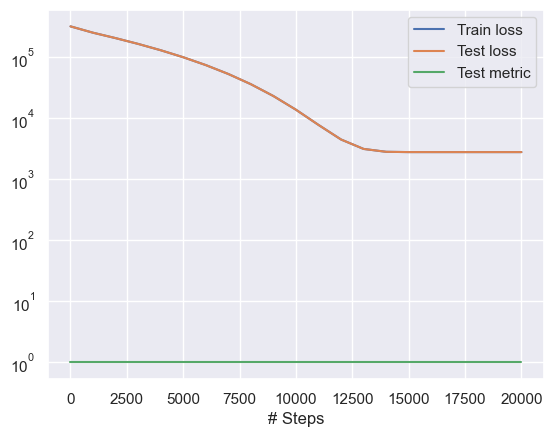

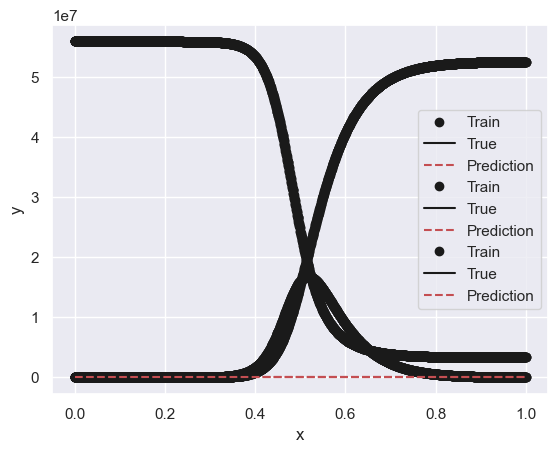

In [23]:
# disable latex for deepxde plots
plt.rc('text', usetex=False)

dde.saveplot(loss_history, train_state, issave=True, isplot=True)